## Class 3 - L1 and L2 regularization
In our lecture, we discussed some foundational concepts in data science, namely *overfitting*, the *bias-variance* trade-off, and *regularization*.
Today, we will apply some of these concepts to interpret and improve the performance of our predictive models, focusing especially on regularization.

AS usual, we will do all of this using `scikit-learn`.

**Note**: As last week, under `nbs/class_03` you will find a notebook called `example.ipynb`, where I provide an example of how to run today's exercise on sample data.
Some of it repeats things done as part of `class_02`, for the sake of completeness.
But you can also:
- just keep working on the same notebook as last week
- work in a new notebook, but load data splits and models that have saved last week

### Today's exercise
Gather in the same group as last week, and please go through the following steps:
1. Look back at last week's notebook. If you have not applied any transformation to your input because you did not have time, spend some time thinking about whether it would make sense to do so. You can find relevant transformations in `scikit-learn`: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing. You will probably mostly be interested in `StandardScaler` and `MinMaxScaler`
2. Look at the performance of the models you've fitted last week: what is the best model? Do you see any evidence of overfitting?
3. Fit your maximal models with `Lasso` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) and `Ridge` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) estimators instead of `LinearRegression`. Make sure you look at the documentation to understand what these do. Fit multiple models with multiple values of alpha and store the outputs;
4. Plot the performance of your models against your linear and KNN models from last week. Does the performance of the model on the validation set improve with regularization?
5. For both `Lasso` and `Ridge` models, plot the value of the coefficients as a function of alpha. You can access the coefficients for a fitted `model` through `model.coef_`. What do you notice in terms of how LASSO versus Ridge behave? (Look at `example.ipynb` for inspiration)
6. Finally, if any models are doing better than the linear model without regularization, select the best `Ridge` and the best `Lasso` model, and plot their coefficients, alongsize coefficients from the simple linear models. How do estimates change with regularization? Which values have changed the most? Do you have any hypothesis as to why?

### Once you have done this
Please submit a pull request to my repository where, within `nbs/class_03/group-x` you have the notebook on which you have worked.
If your notebook is the same as last week, please push that one.

In [81]:
import pandas as pd
import os

#importing bike data
path = os.path.join("..","..","_data", "bike_sharing_dataset", "day.csv")
bike_data = pd.read_csv(path)

bike_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [82]:
import pandas as pd
import os

#importing bike data
path = os.path.join("..","..","_data", "bike_sharing_dataset", "hour.csv")
bike_data = pd.read_csv(path)

# reformating dteday to datetime
bike_data['dteday'] = pd.to_datetime(bike_data['dteday'])

In [83]:
print(bike_data.head())

   instant     dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1 2011-01-01       1   0     1   0        0        6           0   
1        2 2011-01-01       1   0     1   1        0        6           0   
2        3 2011-01-01       1   0     1   2        0        6           0   
3        4 2011-01-01       1   0     1   3        0        6           0   
4        5 2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


In [84]:
from sklearn.model_selection import train_test_split

# We start by selecting the features (X) and the target variable (y)
#X = bike_data['hr']

X = bike_data[['temp', 'atemp', 'hum', 'windspeed']]

y = bike_data['cnt']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Reshaping the data to be 2D if it's not already
X_train = X_train.values.reshape(-1, 1) if len(X_train.shape) == 1 else X_train
X_test = X_test.values.reshape(-1, 1) if len(X_test.shape) == 1 else X_test

# Further splitting the training data into training and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=X_test.shape[0] / X_train.shape[0], random_state=42)

# Reshaping the validation data to be 2D if it's not already
X_val = X_val.values.reshape(-1, 1) if len(X_val.shape) == 1 else X_val

# Saving the splits in a dictionary
datasets = {'X_train': X_train, 'X_val': X_val, 'X_test': X_test, 'y_train': y_train, 'y_val': y_val, 'y_test': y_test}

In [85]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

performances = []


def evaluate(model, X, y, nsplit, model_name, constant_value=None):
    ''' Evaluates the performance of a model 
    Args:
        model (sklearn.Estimator): fitted sklearn estimator
        X (np.array): predictors
        y (np.array): true outcome
        nsplit (str): name of the split
        model_name (str): string id of the model
        constant_value (int or None): relevant if the model predicts a constant
    '''
    if constant_value is not None:
        preds = np.array([constant_value] * y.shape[0])
    else:
        preds = model.predict(X)
    r2 = r2_score(y, preds)
    performance = np.sqrt(mean_squared_error(y, preds))
    performances.append({'model': model_name,
                         'split': nsplit,
                         'rmse': performance.round(4),
                         'r2': r2.round(4)})

Modelling

In [86]:
reg = LinearRegression().fit(X_train, y_train)

evaluate(reg, X_train, y_train, 'train', 'linear regression')
evaluate(reg, X_val, y_val, 'validation', 'linear regression')
evaluate(reg, X_test, y_test, 'test', 'linear regression')

performances = pd.DataFrame(performances)
print(performances)

               model       split      rmse      r2
0  linear regression       train  158.9128  0.2508
1  linear regression  validation  150.4053  0.2538
2  linear regression        test  152.6801  0.2639


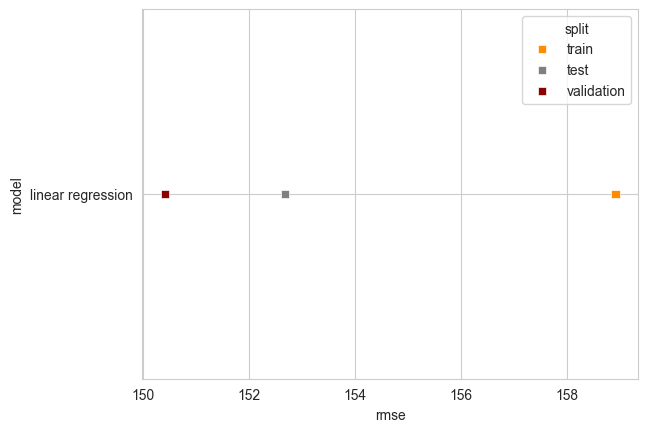

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.scatterplot(data=performances.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

# 

In [ ]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

performances = []

for alpha in [0.01, 0.1, 0.2, 0.5, 1.0, 20.0, 10.0, 100.0, 1000.0]:
    for est in [Lasso, Ridge]:
        id = 'lasso' if est == Lasso else 'ridge'
        reg = est(alpha=alpha).fit(X_train, y_train)
        
        for x, y, nsplit in zip([X_train, X_val, X_test], [y_train, y_val, y_test], ['train', 'val', 'test']):
            preds = reg.predict(x)
            r2 = r2_score(y, preds)
            performance = np.sqrt(mean_squared_error(y, preds))
            performances.append({'model': f'{id}-alpha-{alpha}',
                                 'split': nsplit,
                                 'rmse': performance.round(4),
                                 'r2': r2.round(4)})

# Convert performances to a DataFrame
performances_df = pd.DataFrame(performances)

In [95]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

performances = []

for alpha in [0.01, 0.1, 0.2, 0.5, 1.0, 20.0, 10.0, 100.0, 1000.0]:
    for est in [Lasso, Ridge]:
        id = 'lasso' if est == Lasso else 'ridge'
        reg = est(alpha=alpha).fit(X_train, y_train)
        
        for x, y, nsplit in zip([X_train, X_val, X_test], [y_train, y_val, y_test], ['train', 'val', 'test']):
            preds = reg.predict(x)
            r2 = r2_score(y, preds)
            performance = np.sqrt(mean_squared_error(y, preds))
            performances.append({'model': f'{id}-alpha-{alpha}',
                                 'split': nsplit,
                                 'rmse': performance.round(4),
                                 'r2': r2.round(4)})

# Convert performances to a DataFrame
performances_df = pd.DataFrame(performances)

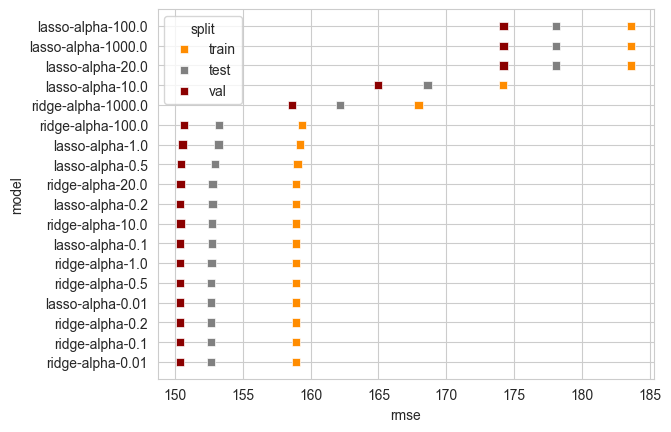

In [96]:
perf_df = pd.DataFrame(performances)
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

In [99]:
# Extract coefficients from each model and stack them into a numpy array
coefficients = np.vstack([model.coef_.round(4) for model in reg.values()])

# Create a DataFrame from the coefficients array
coefficients_df = pd.DataFrame(coefficients, columns=bike_data[['temp', 'atemp', 'hum', 'windspeed']].columns)

# Add 'mtype' and 'alpha' columns to the DataFrame
coefficients_df['mtype'] = [key.split('-')[0] for key in reg.keys()]
coefficients_df['alpha'] = [float(key.split('-')[1]) for key in reg.keys()]

# Melt the DataFrame to long format
coefficients_df = pd.melt(coefficients_df, id_vars=['mtype', 'alpha'])

AttributeError: 'Ridge' object has no attribute 'values'

In [98]:
grid = sns.relplot(data=coefs[coefs['mtype']!='linear'], 
                   x='alpha', y='value', 
                   hue='variable', col='mtype', kind='line')
grid.set(xscale="log")

NameError: name 'coefs' is not defined